In [1]:
import sys
# sys.path.append("/home/diego/python/spike-train/") 
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")
sys.path.append("/home/diego/python/utils/") 
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, LBFGS, RMSprop
# import pickle

from gglm.utils import shift_array
from sptr.sptr import SpikeTrain
from gglm.glm.base import GLM
from gglm.glm.torchglm import TorchGLM
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from processes.ou import OUProcess

%load_ext autoreload
%autoreload 2
plt.close('all')

 epoch 599 of 600 nll 4254.1611Starting gradient ascent... 

 Iteration 170 of 200 | Elapsed time: 13.92 seconds | objective=4257.35
 
 Iteration 170 of 200 | Converged | Elapsed time: 0.2321 minutes | Log posterior is not monotonic 



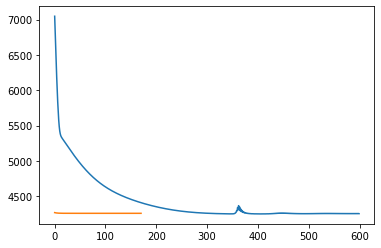

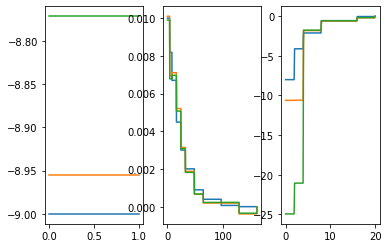

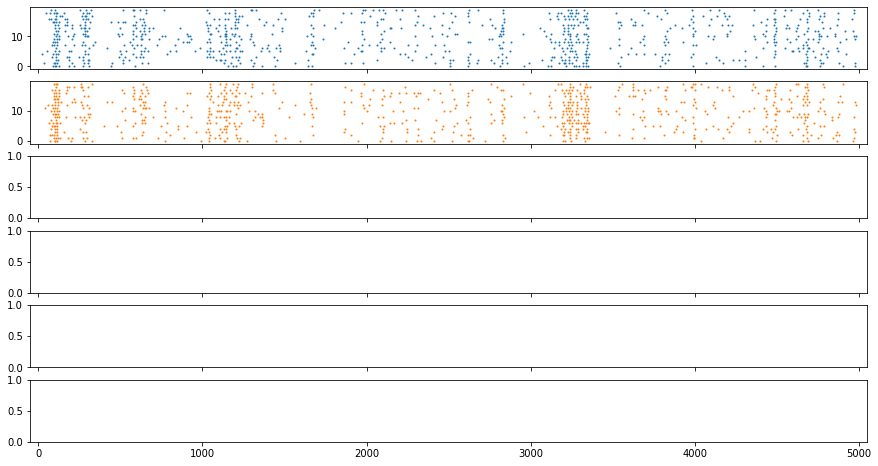

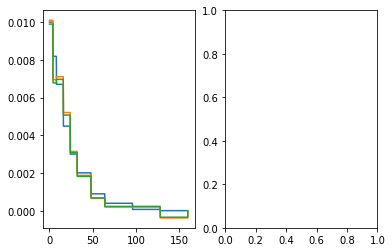

In [21]:
np.random.seed(0)

dt = 1
t = np.arange(0, 5000, 1)

tbins_kappa = np.array([0, 4, 8, 16, 24, 32, 48, 64, 96, 128, 160])
tbins_eta = np.array([0, 2, 4, 8, 16, 20])

R = 2e-1
tau = 20
glm = GLM(u0=-9, kappa=KernelRect(tbins_kappa, R / tau * np.exp(-tbins_kappa[:-1] / tau)), 
           eta=KernelRect(tbins_eta, -8 * np.exp(-tbins_eta[:-1] / 3)))

n = 20

stim = np.zeros((len(t), 1))
stim = OUProcess(mu=15, sd=15, tau=3).sample(t, shape=(1,))
stim = np.stack([stim[:, 0]] * n, 1)

_, _, mask_spikes = glm.sample(t, stim=stim)
# print(np.mean(np.sum(mask_spikes_d1, 0)), np.mean(np.sum(mask_spikes_d2, 0)))

lr, num_epochs = 1e-3, 600
st = SpikeTrain(t, mask_spikes)

glm_fit = TorchGLM(u0=-10, kappa=KernelRect(tbins_kappa, coefs=np.zeros(len(tbins_kappa) - 1) + 1e-3), 
                   eta=KernelRect(tbins_eta, coefs=np.zeros(len(tbins_eta) - 1) - 6), noise='bernoulli')

# glm_fit = TorchGLM(u0=-10, kappa=glm.kappa.coefs(), eta=glm.eta.coefs(), noise='bernoulli')

optim = Adam([{'params': glm_fit.b, 'lr': 2e-2}, 
              {'params': glm_fit.kappa_coefs, 'lr': 1e-4}, 
              {'params': glm_fit.eta_coefs, 'lr': 2e-2}
              ], lr=lr, betas=(0, 0.999))

# optim = LBFGS(glm_fit.parameters(), lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, 
#               history_size=100, line_search_fn=None)
# optim = RMSprop(glm_fit.parameters(), lr=1e-4, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
nll, metrics_list = glm_fit.train(t, torch.from_numpy(mask_spikes), stim=stim, optim=optim, num_epochs=num_epochs, 
                                   verbose=True, metrics=None)

# glm_fit2 = GLM(u0=-10, kappa=KernelRect(tbins_kappa, coefs=np.zeros(len(tbins_kappa) - 1) + 1e-3), 
#                    eta=KernelRect(tbins_eta, coefs=np.zeros(len(tbins_eta) - 1) - 6), noise='poisson')
glm_fit2 = GLM(u0=glm.u0, kappa=glm.kappa.copy(), eta=glm.eta.copy(), noise='poisson')

opt = glm_fit2.fit(t, mask_spikes, stim=stim, verbose=True, 
                  newton_kwargs=dict(learning_rate=1e-1, stop_cond=1e-12, max_iterations=200))

fig, ax = plt.subplots()
ax.plot(nll)
ax.plot(opt.obj_iterations)

u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, stim=stim)
u_dc, r_dc = glm_fit.sample_conditioned(t, mask_spikes, stim=stim)
st_fr = SpikeTrain(t, mask_spikes_fr)

# psth_d = np.mean(st.convolve(ker_gauss), 1)
# psth_fr = np.mean(st_fr.convolve(ker_gauss), 1)

# print('n_spikes', np.mean(np.sum(mask_spikes_fr, 0)))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.plot([0, 1], [glm.u0, glm.u0])
ax1.plot([0, 1], [glm_fit.u0, glm_fit.u0])
ax1.plot([0, 1], [glm_fit2.u0, glm_fit2.u0])
glm.kappa.plot(ax=ax2)
glm_fit.kappa.plot(ax=ax2)
glm_fit2.kappa.plot(ax=ax2)
glm.eta.plot(ax=ax3)
glm_fit.eta.plot(ax=ax3)
glm_fit2.eta.plot(ax=ax3)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(15, 8), nrows=6, sharex=True)
st.plot(ax=ax1, ms=1)
st_fr.plot(ax=ax2, ms=1, color='C1')
# ax3.plot(t, psth_d)
# ax3.plot(t, psth_fr)
# ax4.plot(t, psth_d)

fig, (ax1, ax2) = plt.subplots(ncols=2)
glm.kappa.plot(ax=ax1)
glm_fit.kappa.plot(ax=ax1)
glm_fit2.kappa.plot(ax=ax1)

 epoch 199 of 200 nll 5175.793

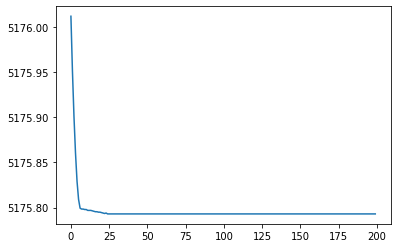

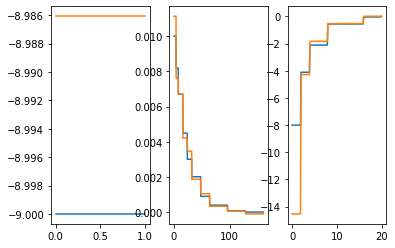

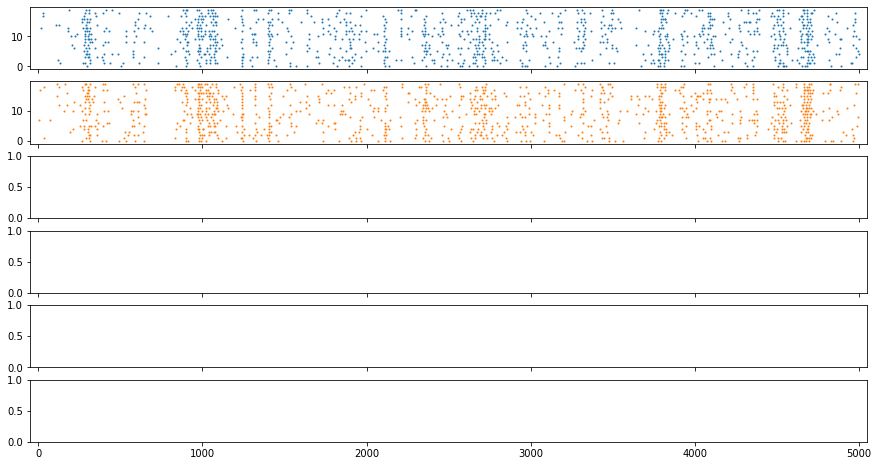

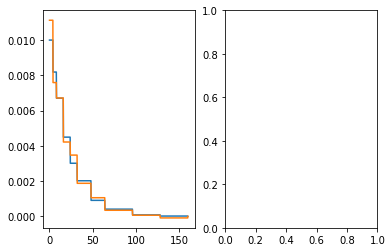

In [106]:
optim = Adam([{'params': glm_fit.b, 'lr': 2e-4}, 
              {'params': glm_fit.kappa_coefs, 'lr': 1e-6}, 
              {'params': glm_fit.eta_coefs, 'lr': 2e-4}
              ], lr=lr, betas=(0, 0))

num_epochs = 200

nll, metrics_list = glm_fit.train(t, torch.from_numpy(mask_spikes), stim=stim, optim=optim, num_epochs=num_epochs, 
                                   verbose=True, metrics=None)

fig, ax = plt.subplots()
ax.plot(nll)

u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, stim=stim)
u_dc, r_dc = glm_fit.sample_conditioned(t, mask_spikes, stim=stim)
st_fr = SpikeTrain(t, mask_spikes_fr)

# psth_d = np.mean(st.convolve(ker_gauss), 1)
# psth_fr = np.mean(st_fr.convolve(ker_gauss), 1)

# print('n_spikes', np.mean(np.sum(mask_spikes_fr, 0)))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.plot([0, 1], [glm.u0, glm.u0])
ax1.plot([0, 1], [glm_fit.u0, glm_fit.u0])
glm.kappa.plot(ax=ax2)
glm_fit.kappa.plot(ax=ax2)
glm.eta.plot(ax=ax3)
glm_fit.eta.plot(ax=ax3)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(15, 8), nrows=6, sharex=True)
st.plot(ax=ax1, ms=1)
st_fr.plot(ax=ax2, ms=1, color='C1')
# ax3.plot(t, psth_d)
# ax3.plot(t, psth_fr)
# ax4.plot(t, psth_d)

fig, (ax1, ax2) = plt.subplots(ncols=2)
glm.kappa.plot(ax=ax1)
glm_fit.kappa.plot(ax=ax1)

In [107]:
X = torch.from_numpy(glm_fit.objective_kwargs(t, mask_spikes, stim=stim)['X']).double()
glm_fit = TorchGLM(u0=glm.u0, kappa=glm.kappa.copy(), eta=glm.eta.copy(), noise='bernoulli')
glm_fit(dt, mask_spikes, X), nll[-1]

(tensor(5179.7854, dtype=torch.float64, grad_fn=<NegBackward>), 5175.79296875)

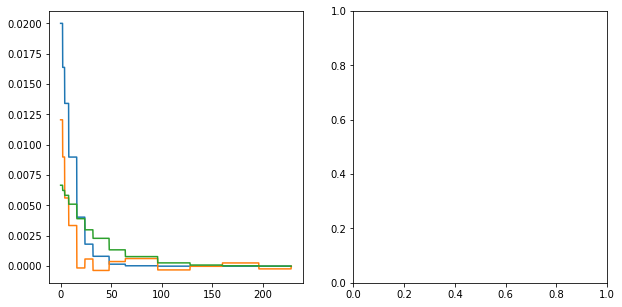

In [191]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
glm1.kappa.plot(ax=ax1)
glm_fit.kappa.plot(ax=ax1)
glm2.kappa.plot(ax=ax1)

-7.591379604984659


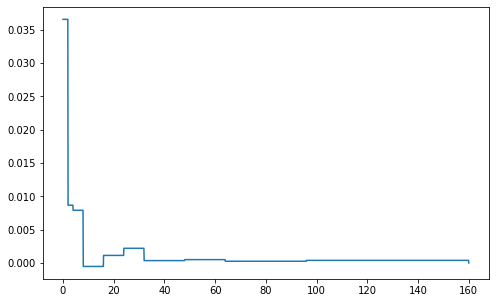

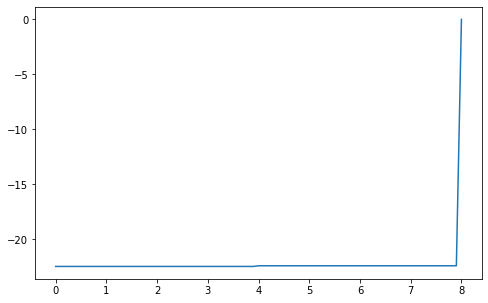

In [51]:
print(glm_fit.u0)
glm_fit.kappa.plot()
glm_fit.eta.plot()

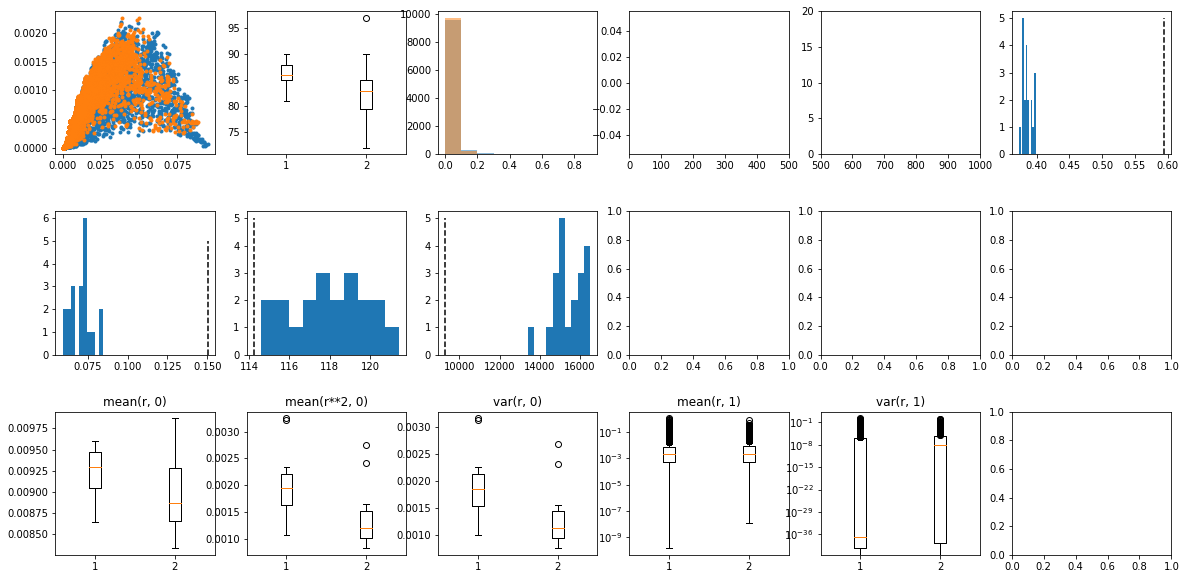

In [20]:
ker = KernelFun.gaussian_delta(4)

rel_te = st_te.reliability(ker, ker)
fano_te = np.mean(st_te.sliding_fano_factor(ker))
rels, fanos = [], []
mean_isis, var_isis = [], []
for ii in range(20):
    _u_fr, _r_fr, _mask_spikes_fr = glm_fit.sample(t, stim=stim)
    _st = SpikeTrain(t, _mask_spikes_fr)
    rels.append(_st.reliability(ker, ker))
    fanos.append(np.mean(_st.sliding_fano_factor(ker)))
    _isi_fr = _st.isi_distribution()
    mean_isis.append(np.mean(_isi_fr))
    var_isis.append(np.var(_isi_fr))

mean_spk_te = st_te.convolve(ker)
mean_spk_fr = st_fr.convolve(ker)
var_spk_te = np.var(mean_spk_te, 1)
var_spk_fr = np.var(mean_spk_fr, 1)
mean_spk_te = np.mean(mean_spk_te, 1)
mean_spk_fr = np.mean(mean_spk_fr, 1)

bins = np.arange(0, 1050, 50)
isi_te = st_te.isi_distribution()
mean_isi_te, var_isi_te = np.mean(isi_te), np.var(isi_te)
isi_fr = st_fr.isi_distribution()

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16, ax17, ax18)) = plt.subplots(figsize=(20, 10), nrows=3, ncols=6)
fig.subplots_adjust(hspace=0.4)
ax1.plot(mean_spk_te, var_spk_te, '.')
ax1.plot(mean_spk_fr, var_spk_fr, '.')

m1, m2 = np.sum(mask_spikes_te, 0), np.sum(mask_spikes_fr, 0)
ax2.boxplot(x=(m1, m2));
m1, m2 = np.mean(mask_spikes_te, 1), np.mean(mask_spikes_fr, 1)
bins = np.arange(0, 1, .1)
ax3.hist(m1, alpha=0.5, bins=bins);
ax3.hist(m2, alpha=0.5, bins=bins);

ax4.hist(isi_te, bins=bins, alpha=0.5);
ax4.hist(isi_fr, bins=bins, alpha=0.5);
ax4.set_xlim(0, 500)
ax5.hist(isi_te, bins=bins, alpha=0.5);
ax5.hist(isi_fr, bins=bins, alpha=0.5);
ax5.set_xlim(500, 1000)
ax5.set_ylim(0, 20)

ax6.hist(rels)
ax6.plot([rel_te, rel_te], [0, 5], 'k--')
ax7.hist(fanos)
ax7.plot([fano_te, fano_te], [0, 5], 'k--')

ax8.hist(mean_isis)
ax8.plot([mean_isi_te, mean_isi_te], [0, 5], 'k--')
ax9.hist(var_isis)
ax9.plot([var_isi_te, var_isi_te], [0, 5], 'k--')

r1, r2 = np.mean(r_te, 0), np.mean(r_fr, 0)
ax13.boxplot(x=(r1, r2))
ax13.set_title('mean(r, 0)')

r1, r2 = np.mean(r_te**2, 0), np.mean(r_fr**2, 0)
ax14.boxplot(x=(r1, r2))
ax14.set_title('mean(r**2, 0)')

r1, r2 = np.var(r_te, 0), np.var(r_fr, 0)
ax15.boxplot(x=(r1, r2))
ax15.set_title('var(r, 0)')
# ax14.set_yscale('log')

r1, r2 = np.mean(r_te, 1), np.mean(r_fr, 1)
ax16.boxplot(x=(r1, r2))
ax16.set_title('mean(r, 1)')
ax16.set_yscale('log')

r1, r2 = np.var(r_te, 1), np.var(r_fr, 1)
ax17.boxplot(x=(r1, r2))
ax17.set_title('var(r, 1)')
ax17.set_yscale('log')